In [3]:
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LeakyReLU
from tensorflow.keras import layers, losses
from tensorflow.keras.optimizers import Adam
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from enum import Enum
import PIL
import PIL.Image
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping 
from PIL import Image
import random

2023-12-03 15:24:20.833706: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-03 15:24:20.836666: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-03 15:24:20.882782: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-03 15:24:20.883519: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-03 15:24:21.735669: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [12]:
# GLOBAL VARIABLES 
os.chdir("/home/linus/WashUCoding/DIS Copenhagen/Neural Networks/TomJerryProject")
print("Working Directory:", os.getcwd())
# directories containing desired output, i.e. our y-labels, the ground truth 

base_path = "ObjectDetectedDataset/"
inputTrainPath = base_path + "train/edge_detected"
inputTestPath = base_path + "test/edge_detected" 

outputTrainPath = base_path + "train/tom_jerry_images"
outputTestPath = base_path + "test/tom_jerry_images"

trainingDirectories = [inputTrainPath, outputTrainPath]
testingDirectories = [inputTestPath, outputTestPath]

Working Directory: /home/linus/WashUCoding/DIS Copenhagen/Neural Networks/TomJerryProject


In [13]:
# HELPER FUNCTIONS
""" Returns file paths for all images in the input and output directories

    Returns:
        List(Tuples): each tuple contains paths to two corresponding images, the first is the edge-filtered image, the second is the unaltered image
"""
def getFilePaths(inputDirectories, outputDirectories): 
    dataset = []
    for inputDir, outputDir in zip(inputDirectories, outputDirectories): 
        fileNames = os.listdir(inputDir)
        for fileName in fileNames: 
            inputImagePath = os.path.join(inputDir, fileName)
            outputImagePath = os.path.join(outputDir, fileName)
            dataset.append((inputImagePath, outputImagePath))
    return dataset

# takes in two paths of paired images, 
# optionally, one can specify the desired resolution of the image
# whether to display the retrieved images, and whether to convert the images to RGB
# will return the two images as numpy arrays, normalized by dividing by 255
""" Returns two images as two numpy arrays, normalized by dividing by 255

    Args: 
        input_file_path (str): path to an edge-filtered image
        output_file_path (str): path corresponding to the un-modified image of the input_file_path
        image_shape Tuple(int, int): desired width and length of the image
        showImages (boolean): whether to display both images using matplotlib
        isRGB (boolean): whether to convert

    Returns: 
        (np.array, np.array): Two rescaled numpy arrays, representing two images
"""
def loadImage(input_file_path, output_file_path, 
              image_shape=(400, 200), showImages=False, isRGB = True): 

    input_image = Image.open(input_file_path).resize(image_shape)
    output_image = Image.open(output_file_path).resize(image_shape)
    beforeGrayScale = np.array(input_image)
    # print("Inside loadImage():", np.min(beforeGrayScale), np.max(beforeGrayScale))

    # convert to greyscale if desired
    if not isRGB: 
        input_image = input_image.convert("L")
        output_image = output_image.convert("L")
    else: 
        input_image = input_image.convert("RGB")
        output_image = output_image.convert("RGB")

    # if desired, display the retrieved images
    if showImages: 
        # Display images for testing
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.imshow(np.array(input_image))
        plt.title("Input Image")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(np.array(output_image))
        plt.title("Ground Truth Image")
        plt.axis('off')

        plt.show()
    # for some reason, max pixel value from edge_detected images is 118.0
    return np.array(input_image)/118.0, np.array(output_image)/255.0


In [16]:
trainingPaths = getFilePaths([trainingDirectories[0]], [trainingDirectories[1]])
testingPaths = getFilePaths([testingDirectories[0]], [testingDirectories[1]])

maxesOfInput = []
maxesOfOutput = []
# for i in range(len(paths)): 
#     randomNum = random.randint(0, len(paths)-1)
#     result = loadImage(paths[randomNum][0], paths[randomNum][1], image_shape=(28,28), showImages=False, isRGB=False)
#     maxesOfInput.append(np.max(result[0]))
#     maxesOfOutput.append(np.max(result[1]))
    # print(np.min(result[0]), np.max(result[0]))
    # print(np.min(result[1]), np.max(result[1]))
# print(max(maxesOfInput))
# print(max(maxesOfOutput))


In [19]:
# CREATION OF TRAINING AND TESTING DATASETS

# randomize paths so images are randomly allocated into training/testing datasets
# random.shuffle(paths)
validation_split = 0.2

x_train, y_train = [], []
x_test, y_test = [], []


# THIS VARIABLE AFFECTS THE DIMENSIONS OF ALL IMAGES IN THE DATASET
# IT WILL ALSO AFFECT THE SHAPE OF THE AUTO_ENCODER
personal_image_shape = (256, 256)
for train_input_path, train_output_path in trainingPaths: 
    inputImage, outputImage = loadImage(train_input_path, train_output_path, image_shape=personal_image_shape, isRGB=False, showImages=False)
    x_train.append(inputImage)
    y_train.append(outputImage)

for train_input_path, train_output_path in testingPaths: 
    inputImage, outputImage = loadImage(train_input_path, train_output_path, image_shape=personal_image_shape, isRGB=False, showImages=False)
    x_test.append(inputImage)
    y_test.append(outputImage)


# print(np.min(result[0]/255.0), np.max(result[0]/255.0))
# print(np.min(result[1]/255.0), np.max(result[1]/255.0))

In [20]:
# Confirming sizes of datsets and shapes of the datasets
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))
x_train, y_train, x_test, y_test = np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

983 983
368 368
(983, 256, 256)
(983, 256, 256)
(368, 256, 256)
(368, 256, 256)


In [21]:
# following guidance from the below link
# https://www.tensorflow.org/tutorials/load_data/numpy
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)


In [16]:
class AutoencoderWithDense(Model):
    def __init__(self, latent_dim, dropout_rate=0.4):
        super(AutoencoderWithDense, self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            # layers.Dense(8192, activation="relu"), # Added Dense
            # layers.Dropout(dropout_rate), 
            # layers.Dense(4096, activation="relu"), # Added Dense
            # layers.Dropout(dropout_rate), 
            layers.Dense(2048, activation="relu"), # Added Dense
            layers.Dropout(dropout_rate), 
            layers.Dense(1024, activation="relu"), # Added Dense
            layers.Dropout(dropout_rate), 
            # layers.Dense(512, activation="relu"), # Added Dense
            # layers.Dropout(dropout_rate), 
            layers.Dense(latent_dim, activation='relu'),
            ])
        self.decoder = tf.keras.Sequential([
            # layers.Dense(512, activation="relu"), # Added Dense
            # layers.Dropout(dropout_rate), 
            layers.Dense(1024, activation="relu"), # Added Dense
            layers.Dropout(dropout_rate), 
            layers.Dense(2048, activation="relu"), # Added Dense
            layers.Dropout(dropout_rate), 
            # layers.Dense(4096, activation="relu"), # Added Dense
            # layers.Dropout(dropout_rate), 
            # layers.Dense(8192, activation="relu"), # Added Dense
            layers.Dense(personal_image_shape[1] * personal_image_shape[0], activation='sigmoid'),
            layers.Reshape((personal_image_shape[1], personal_image_shape[0])) # is reversed from other functions
            # layers.Reshape((100, 200)) # is reversed from other functions
            ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [21]:
autoencoder_with_dense = AutoencoderWithDense(latent_dim = 150)
autoencoder_with_dense.compile(optimizer='adam', 
                               loss=losses.MeanSquaredError())
                              #  loss=losses.MeanAbsoluteError())
                              #  loss=losses.BinaryCrossentropy())

callback = EarlyStopping(monitor="val_loss", patience = 15)

history = autoencoder_with_dense.fit(train_dataset,
                epochs=1000,
                shuffle=True,
                validation_data=(test_dataset), 
                callbacks=callback)


Epoch 1/1000


2023-11-30 20:11:10.792351: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (mklcpu) ran out of memory trying to allocate 512.00MiB (rounded to 536870912)requested by op gradient_tape/autoencoder_with_dense_3/sequential_7/dense_25/MatMul/MatMul_1
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-11-30 20:11:10.795257: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for mklcpu
2023-11-30 20:11:10.795281: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2023-11-30 20:11:10.795292: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2023-11-30 20:11:10.795

ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/autoencoder_with_dense_3/sequential_7/dense_25/MatMul/MatMul_1' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "/home/linus/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/linus/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/home/linus/anaconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 736, in start
      self.io_loop.start()
    File "/home/linus/anaconda3/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/home/linus/anaconda3/lib/python3.11/asyncio/base_events.py", line 607, in run_forever
      self._run_once()
    File "/home/linus/anaconda3/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once
      handle._run()
    File "/home/linus/anaconda3/lib/python3.11/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/linus/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "/home/linus/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "/home/linus/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
      await result
    File "/home/linus/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "/home/linus/anaconda3/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/home/linus/anaconda3/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/linus/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "/home/linus/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "/home/linus/anaconda3/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/linus/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/linus/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/linus/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_16151/817995310.py", line 9, in <module>
      history = autoencoder_with_dense.fit(train_dataset,
    File "/home/linus/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/linus/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/linus/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "/home/linus/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/linus/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "/home/linus/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1084, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/home/linus/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/optimizer.py", line 543, in minimize
      grads_and_vars = self.compute_gradients(loss, var_list, tape)
    File "/home/linus/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/optimizer.py", line 276, in compute_gradients
      grads = tape.gradient(loss, var_list)
Node: 'gradient_tape/autoencoder_with_dense_3/sequential_7/dense_25/MatMul/MatMul_1'
OOM when allocating tensor with shape[2048,65536] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator mklcpu
	 [[{{node gradient_tape/autoencoder_with_dense_3/sequential_7/dense_25/MatMul/MatMul_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_17340]

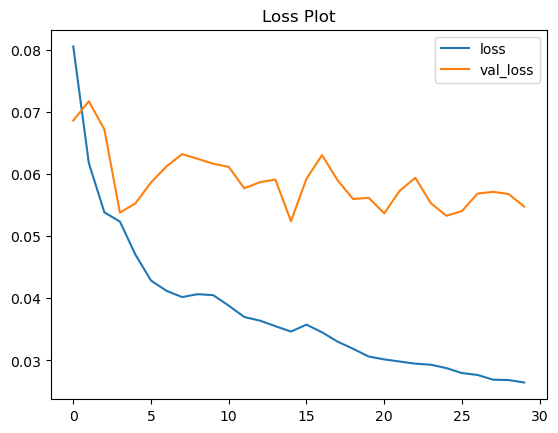

In [19]:
# print training and value loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("Loss Plot")
plt.legend()

7/7 [==============================] - 0s 58ms/step


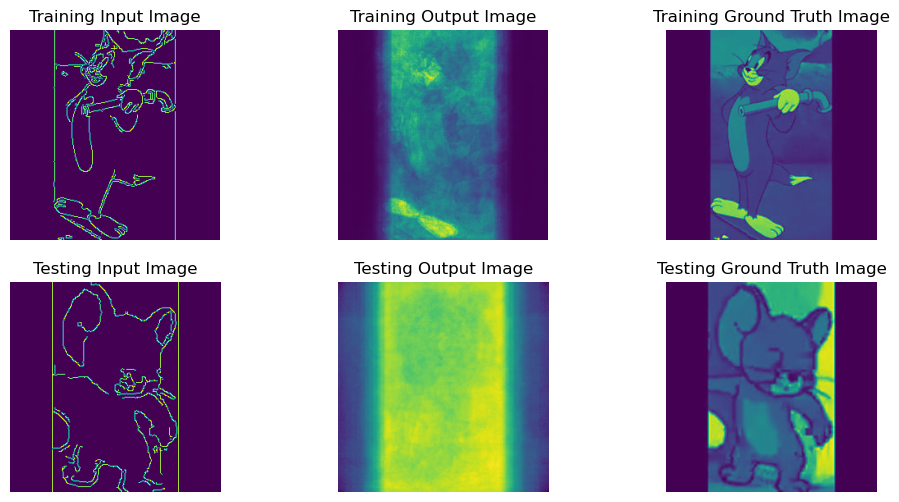

In [20]:
# Display images for testing

trainImageIndex = random.randint(0, len(x_train)-1)
testImageIndex = random.randint(0, len(x_test)-1)
train_output_image = autoencoder_with_dense.predict(x_train)[trainImageIndex]
test_output_image = autoencoder_with_dense.predict(x_test)[testImageIndex]

plt.figure(figsize=(12, 6))

plt.subplot(2, 3, 1)
plt.imshow(np.array(x_train[trainImageIndex]))
plt.title("Training Input Image")
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(np.array(train_output_image))
plt.title("Training Output Image")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(np.array(y_train[trainImageIndex]))
plt.title("Training Ground Truth Image")
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(np.array(x_test[testImageIndex]))
plt.title("Testing Input Image")
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(np.array(test_output_image))
plt.title("Testing Output Image")
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(np.array(y_test[testImageIndex]))
plt.title("Testing Ground Truth Image")
plt.axis('off')

plt.show()

In [12]:
autoencoder_with_dense.save("src/SavedModels/DenseModel2.keras")